### Problem 3.2: HIV clearance and a warning about regressions (30 pts)

A human immunodeficiency virus (HIV) is a virus that causes host organisms to develop a weaker, and sometimes ineffective, immune system. HIV inserts its viral RNA into a target cell of the immune system.  This virus gets reverse transcribed into DNA and integrated into the host cell's chromosomes.  The host cell will then transcribe the integrated DNA into mRNA for the production of viral proteins and produce new HIV.  Newly created viruses then exit the cell by budding off from the host.  HIV carries the danger of ongoing replication and cell infection without termination or immunological control.  Because CD4 T cells, which communicate with other immune cells to activate responses to foreign pathogens, are the targets for viral infection and production, their infection leads to reductions in healthy CD4 T cell production, causing the immune system to weaken.  This reduction in the immune response becomes particularly concerning after remaining infected for longer periods of time, leading to acquired immune deficiency syndrome (AIDS).

Perelson and coworkers have developed mathematical models to study HIV populations in the eukaryotic organisms.  HIV-1 infects cells at a rate $k$ and is produced from these infected T cells at a rate $p$.  On the other hand, the viruses are lost due to clearance by the immune system of drugs, which occurs at a rate $c$, and infected cells die at a rate $\delta$ (Figure from [Perelson, *Nat. Rev. Immunol.*, **2**, 28-36, 2002](../protected/papers/perel_son2002.pdf))

![/Basic model of viral infection](hiv_figure.jpg "Basic model of viral infection Perelson Nat. Rev. Immunol. 2002)")

The above process can be written down as a system of differential equations.

\begin{align}
\frac{dT^*}{dt} &= k V_I T - \delta T^*\\[1em]
\frac{dV_I}{dt} &= -cV_I\\[1em]
\frac{dV_{NI}}{dt} &= N \delta T^{*} - c V_{NI},
\end{align}

Here, $T(t)$ is the number of uninfected T-cells at time $t$, and $T^*$ is the number of infected T cells. Furthermore, there is a concentration $V_I(t)$ of infectious viruses that infect T cells at the rate $k$.  We also have a concentration $V_{NI}$ of innocuous viruses. We define $N(t)$ to be the number of newly produced viruses from one infected cell over this cell's lifetime.  We can measure the total viral load, $V(t) = V_I(t) + V_{NI}(t)$.  If we initially have a viral load of $V(0) = V_0$, we can solve the system of differential equations to give

\begin{align}
V(t) = V_0e^{-ct} + \frac{cV_0}{c-\delta}\left[\frac{c}{c-\delta}(e^{-{\delta}t} - e^{-ct}) - {\delta}te^{-ct}\right].
\end{align}

We will take viral load data from a real patient (which you can download [here](data/hiv_data.csv)) and perform a regression to evaluate the parameters $c$ and $\delta$.  The patient was treated with the drug Ritonavir, a protease inhibitor that serves to clear the viruses; i.e., it modulates $c$. So, in the context of the model, $c$ is a good parameter to use to understand the efficacy of a drug.

**a)** Perform a regression on these data using the theoretical temporal curve for the viral load. That is, obtain estimates for $V_0$, $c$, and $\delta$ but finding the MAP and computing error bars.

**b)** Plot the posterior distribution over the interval $0 \le \delta, c \le 10$ days$^{-1}$.  Does this plot raise any serious issues about how you estimate $c$ and $d$?  What experiments might you propose to help deal with these problems? *Hint*: In order to compute the marginalized posterior,

\begin{align}
P(c, \delta \mid D, I) = \int_0^\infty \mathrm{d}V_0 P(c, \delta, V_0 \mid D, I),
\end{align}

you can perform numerical quadrature using functions like `np.trapz()`. If you are having trouble doing that, make a plot of $P(c, \delta, V_0 \mid D, I)$ in the $c$-$\delta$ plane with $V_0$ fixed at its most probable value.

<br />

In [1]:
import math as m
import numpy as np
import pandas as pd
import scipy.optimize
import statsmodels.tools.numdiff as smnd

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Some pretty Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline
%matplotlib inline

In [2]:
# Load data into DataFrame
df = pd.read_csv('../data/hiv_data.csv', comment='#')

# Check it out
df.head()

,Days after administration,RNA copies per mL
0,0.0000,106100.0
1,0.0831,93240.0
2,0.1465,166720.0
3,0.2587,153780.0
4,0.4828,118800.0


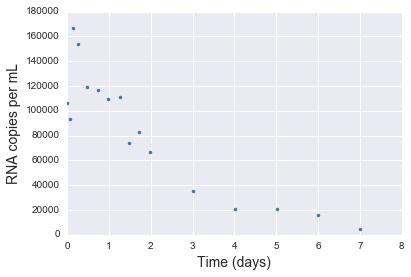

In [3]:
plt.plot(df['Days after administration'], df['RNA copies per mL'], marker='.', linestyle='none')
plt.xlabel('Time (days)')

plt.ylabel('RNA copies per mL')

In [7]:
days = df['Days after administration'].dropna()
copies = df['RNA copies per mL'].dropna()

In [8]:
def findViralLoad(parameters, time):
    '''  
    Theoretical model for the viral load
    '''
    v, c, g = parameters
    return v*m.e**(-c*time) + c*v/(c-g) * ((c/(c-g) * (m.e**(-g*time) - m.e**(-c*time)) - g*time*m.e**(-c*time)))

In [9]:
def log_post(parameters, time, viralLoad):
    """
    Compute log of posterior for single set of parameters.
    parameters[0] = v
    parameters[1] = c
    parameters[2] = g   
    """
    # Unpack parameters
    v, c, g = parameters
    
    # Theoretical viral load
    viralTheoretical = findViralLoad(parameters, time)
    
    return -len(time) / 2 * np.log(np.sum((viralLoad - viralTheoretical)**2))

In [10]:
def resid(parameters, time, viralLoad):
    """
    Residuals for the fluorescence model.
    """
    return viralLoad - findViralLoad(parameters, time)

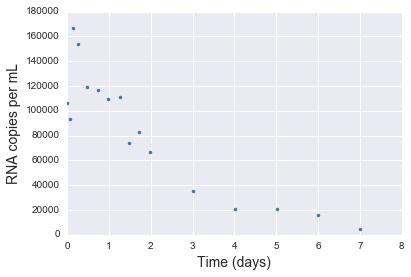

In [11]:
plt.plot(df['Days after administration'], df['RNA copies per mL'], marker='.', linestyle='none')
plt.xlabel('Time (days)')
plt.ylabel('RNA copies per mL')

For our initial estimates, we take V$_0$ to be 1.061 e05 which is the initial load, 23 to be the value of c as stated to be the mean in the paper, and 24 * ln(2) to be the value of $\delta$ given that the paper states that ~1 hr is the mean half-life of HIV. 

In [12]:
p0 = np.array([1.061 * 10**5, 23, 16.6355323334])

In [13]:
args = (days.values, copies.values)

In [14]:
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)

In [15]:
popt

array([  1.29316311e+05,   2.63575416e+00,   5.31356012e-01])

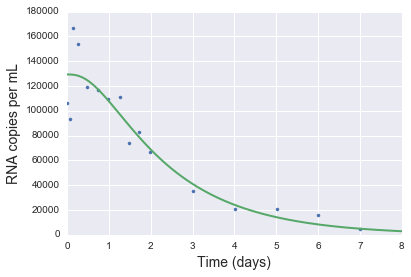

In [16]:
plt.plot(days, copies, marker='.', linestyle='none')
x = np.linspace(0,8,200)
y = findViralLoad(popt, x)
plt.plot(x,y)
totalSum = 0   
plt.xlabel('Time (days)')
plt.ylabel('RNA copies per mL')

In [188]:
hes = smnd.approx_hess(popt, log_post, args=args)
hes

array([[ -2.96012024e-08,   1.62329273e-04,   9.52525733e-04],
       [  1.62329273e-04,  -2.36481750e+00,  -1.53444170e+01],
       [  9.52525733e-04,  -1.53444170e+01,  -1.26742848e+02]])

In [189]:
cov = -np.linalg.inv(hes)

In [190]:
cov

array([[  5.52952148e+07,   5.12591356e+03,  -2.05013856e+02],
       [  5.12591356e+03,   2.44713507e+00,  -2.57744692e-01],
       [ -2.05013856e+02,  -2.57744692e-01,   3.75536855e-02]])

In [191]:
err_v = np.sqrt(cov[0,0])
err_c = np.sqrt(cov[1,1])
err_g = np.sqrt(cov[2,2])
print ('The error for V_0 is', err_v)
print ('The error for c is', err_c)
print ('The error for delta is', err_g)

The error for V_0 is 7436.07522969
The error for c is 1.56433214949
The error for delta is 0.193787733076


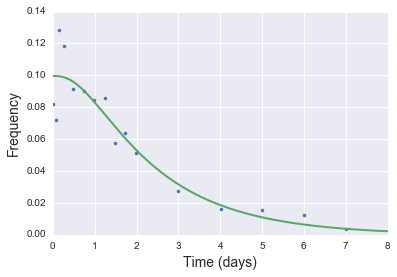

In [192]:
for i in copies.values:
    totalSum += i
args = (days.values, copies.values/float(totalSum))
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)
copies1 = copies/float(totalSum)
plt.plot(days, copies1, marker='.', linestyle='none')
x = np.linspace(0,8,200)
y = findViralLoad(popt, x)
plt.plot(x,y)
plt.xlabel('Time (days)')
plt.ylabel('Frequency')

<div class="alert alert-info">Very good work with the regression. Also, it is good pratice to report the mean and error to the same degree of precision. In your function for the model you should consider the case when $d \approx c$ because in that case the function blows up. As a result, it is always useful take a limit as c tends to d and return that when c is very close to d. It is good to consider the error within $10^{-9}$ rather than 0 because Python has floating point errors. When you take the limit as c tends to d, you will get: $$\lim_{c\to\delta}V(t) = V_0e^{-ct} + \frac{cV_0}{c-\delta}\left[\frac{c}{c-\delta}(e^{-{\delta}t} - e^{-ct}) - {\delta}te^{-ct}\right] = V_0e^{-\delta t}(1 + \delta t + \frac{\delta^2t^2}{2})$$ Score: 15/20</div>

Normalized plot.

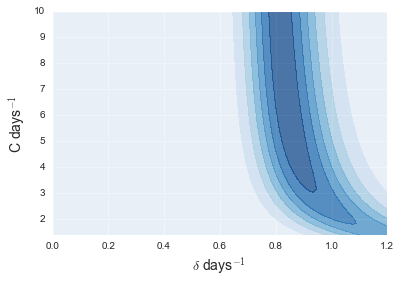

In [204]:
# Parameter values to plot
delta = np.linspace(0, 1.2, 100)
c = np.linspace(1.4, 10, 100)

# Make a grid
tt, gg = np.meshgrid(delta, c)
days1 = df['Days after administration']
copies1 = df['RNA copies per mL']
# Compute log posterior
log_posterior = np.empty_like(tt)
for j in range(len(delta)):
    for i in range(len(c)):
        log_posterior[i, j] = log_post(np.array([1.29316311* 10**5,tt[i,j], gg[i,j]]), days1, copies1)

# Get things to scale better
log_posterior -= log_posterior.max()
        
# Plot the results
plt.contourf(delta, c, np.exp(log_posterior), cmap=plt.cm.Blues, alpha=0.7)
plt.xlabel(r'$\delta$ days$^{-1}$ ')
plt.ylabel(r'C days$^{-1}$ ')

Yes, this plot raises serious issues about our estimation of c and $\gamma$. To find the error bars, we approximate the posterior as a Gaussian, which doesn't necessarily hold for all distributions. In particular, if the distribution is multimodal or very slanted to either side, concentrating on the peak may lead to inaccurate parameter estimates. Another possible complication stems from our assumption that the underlying causes that trigger errors are independent of one another. For most practical applications, this assumption is justified - yet it is not necessarily the case. If so, the parameters that minimize the difference between the theoretical curve and the measurements might not match the actual parameters at all. As we see above, for both delta and C, the estimates don't match the plot of the posterior at all. (By the way, the plot is that of the posterior at V0 evaluated at its point of maximal likelihood.) 

To improve our estimates, we have to get more data points! The data set belongs to a single measurement, and if we could change the factors that affect cell death rate and viral death rate (such as temperature, pressure, humidity etc), then we can test the parameters under various conditions and get a more robust result. Also, at each iteration of the experiment, updating the prior based on the former posterior is likely to help us approach the parameters of interest, for a large number of data points and iterative steps. 

<div class="alert alert-info">You should always plot the posterior over the entire parameter range! This posterior actually has 2 maximum, which is crucial to the problem. I also noticed that you used a fixed $V_0$ rather than marginalization, which is fine here. However, in general marginalization is more accurate because you get a posteiror over en entire parameter space. Score: 5/10</div>